In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator  # interval in axis of charts
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import seaborn as sns

import warnings

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')

In [61]:
import os

for dirname, _, filenames in os.walk('input/'):
    for filename in filenames:
        print(f'./{dirname}/{filename}')

./input/real_estate_price_prediction_moscow/sample_submission.csv
./input/real_estate_price_prediction_moscow/test.csv
./input/real_estate_price_prediction_moscow/train.csv


In [62]:
TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'

In [63]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [64]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [65]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
# train_df = reduce_mem_usage(train_df)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


In [66]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [67]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B


In [68]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [69]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

In [70]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### 1. EDA

In [71]:
# error corection in titles and delete id исправление ошибок
train_df.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)        
train_df = reduce_mem_usage(train_df)
train_df.head(3)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750


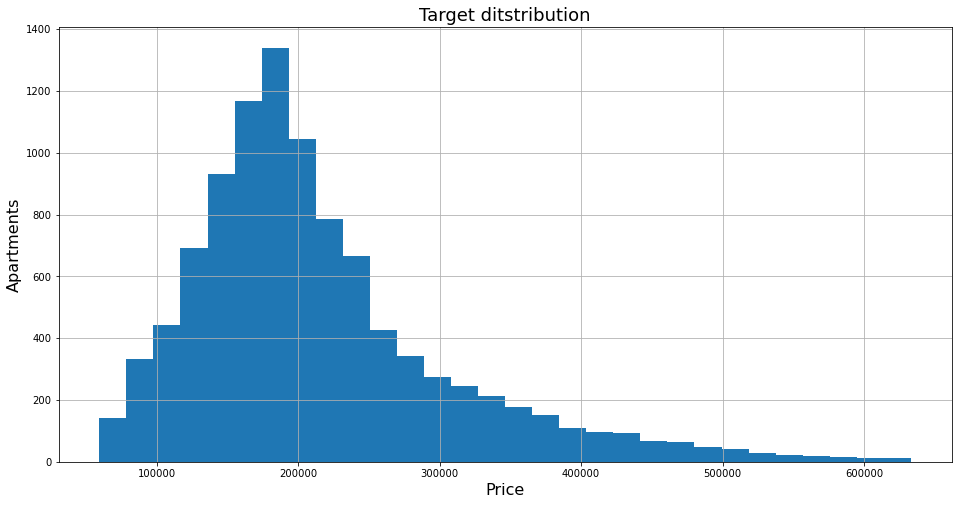

In [72]:
plt.figure(figsize=(16, 8))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=16)
plt.ylabel('Apartments', fontsize=16)
plt.title('Target ditstribution', fontsize=18)
plt.show()

#### ~ Quantitative variables

In [73]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### ~ Nominative variables

In [74]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

### 2. Processing of emissions + NaN

#### Conditions

In [75]:
# LifeSquare: NaN | > 200 | < 5
cLife = (train_df['LifeSquare'].isna()) | (train_df['LifeSquare'] > 200) | (train_df['LifeSquare'] < 5)

# KitchenSquare: NaN | > 60 | < 3
cKitn = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > 60) | (train_df['KitchenSquare'] < 3)

# Square: NaN | > 250 | < 8 | < (LifeSquare + KitchenSquare + 3)
cSquare = (train_df['Square'].isna()) | (train_df['Square'] > 250) | (train_df['Square'] < 8) | \
(train_df.loc[~cLife & ~cKitn, 'Square'] < \
 (train_df.loc[~cLife & ~cKitn, 'LifeSquare'] + train_df.loc[~cLife & ~cKitn, 'KitchenSquare'] + 3))

#### mean ratios

In [76]:
# LifeSquare.median / Square.median
LifeBySquare = train_df.loc[~cLife & ~cSquare, 'LifeSquare'].median() / train_df.loc[~cLife & ~cSquare, 'Square'].median()
LifeBySquare

0.6415035755793791

In [77]:
# KitchenSquare.median / Square.median
KitnBySquare = train_df.loc[~cKitn & ~cSquare, 'KitchenSquare'].median() / train_df.loc[~cLife & ~cSquare, 'Square'].median()
KitnBySquare

0.1579320221582825

#### 1. ~ LifeSquare

In [78]:
# _LifeSquareBug
train_df['_LifeSquareBug'] = 0
train_df.loc[cLife, '_LifeSquareBug'] = 1

# condition --> 'LifeSquare' = Square * LifeBySquare
train_df.loc[cLife, 'LifeSquare'] = train_df.loc[cLife, 'Square'] * LifeBySquare

# max 200

train_df.loc[train_df['LifeSquare'] > 200, 'LifeSquare'] = 200

# round and type
train_df['LifeSquare'] = train_df['LifeSquare'].round().astype(int)
train_df[train_df['_LifeSquareBug'] == 1].shape

(2283, 21)

#### 2. ~ KitchenSquare

In [79]:
# _KitchenSquareBug
train_df['_KitchenSquareBug'] = 0
train_df.loc[cKitn, '_KitchenSquareBug'] = 1

# condition --> 'KitchenSquare' = 'KitchenSquare'.median
train_df.loc[cKitn, 'KitchenSquare'] = train_df.loc[cKitn, 'Square'] * KitnBySquare

# max 60
# max kitchen in the apartment Moscow square = 60 m^2
train_df.loc[train_df['KitchenSquare'] > 60, 'KitchenSquare'] = 60

# round and type
train_df['KitchenSquare'] = train_df['KitchenSquare'].round().astype(int)
train_df[train_df['_KitchenSquareBug'] == 1].shape

(3175, 22)

#### 3. ~ Square

In [80]:
# _SquareBug
train_df['_SquareBug'] = 0
train_df.loc[cSquare, '_SquareBug'] = 1

# condition --> Square = (LifeSquare + KitchenSquare) / (LifeBySquare + KitnBySquare)
train_df.loc[cSquare, 'Square'] = \
(train_df.loc[cSquare, 'LifeSquare'] + train_df.loc[cSquare, 'KitchenSquare']) / ((LifeBySquare + KitnBySquare))

# max Square 250
LKS = (train_df.loc[train_df['Square'] > 250, 'LifeSquare'] + train_df.loc[train_df['Square'] > 250, 'KitchenSquare'])

train_df.loc[train_df['Square'] > 250, 'Square'] = LKS * (1 - (LifeBySquare + KitnBySquare))/ (LifeBySquare + KitnBySquare) 

train_df['Square'] = train_df['Square'].round().astype(int)
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,_LifeSquareBug,_KitchenSquareBug,_SquareBug
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,57.156500,37.167100,8.544400,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500,0.228300,0.317500,0.040200
std,4859.01902,43.587592,0.839522,20.114444,16.478681,3.344839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438,0.419758,0.465527,0.196438
min,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,42.000000,25.000000,6.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,53.000000,34.000000,8.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,67.000000,45.000000,10.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938,0.000000,1.000000,0.000000
max,16798.00000,209.000000,19.000000,238.000000,200.000000,60.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000


In [81]:
train_df[train_df['Square'] == train_df['Square'].max()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,_LifeSquareBug,_KitchenSquareBug,_SquareBug
5283,11055,151,1.0,238,175,15,10,12.0,1958,0.236108,...,3893,27,NaN,3,10,B,232766.1875,0,0,1


#### 4. ~ Rooms

In [83]:
train_df['Rooms'] = train_df['Rooms'].round().astype(int)
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [84]:
# _RoomsOutlier
train_df['_RoomsOutlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), '_RoomsOutlier'] = 1

# Rooms == 0 --> 1
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

# Rooms >= 6 --> Rooms.median
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

#### 5. ~ DistrictId

In [85]:
# DistrictId == NaN --> median DistrictId and main features

def DistrictIdMedian(feature='DistrictId'):
    condDistrictId = train_df['DistrictId'].isna()
    
    train_df.loc[condDistrictId, feature] = 111111 \
    if feature == 'DistrictId' \
    else train_df[feature].median()


for val in ['Square', 'LifeSquare', 'KitchenSquare', 'Rooms', 'DistrictId']:
    DistrictIdMedian(val)

#### 6. ~ HouseYear

In [86]:
train_df.loc[(train_df['HouseYear'] < 1900), 'HouseYear'] = 1900
train_df.loc[(train_df['HouseYear'] > 2020), 'HouseYear'] = 2020

#### 7. ~ HouseFloor

In [87]:
# The Building (with appartmens) with Max Floor in Moscow = 76 floors
train_df.loc[(train_df['HouseFloor'] > 76), 'HouseFloor'] = 76

condition = (train_df['HouseFloor'] <= 0) | (train_df['HouseFloor'] < train_df['Floor'])

train_df.loc[condition, 'HouseFloor'] = train_df.loc[condition, 'Floor']
train_df['HouseFloor'] = train_df['HouseFloor'].round().astype(int)

#### 8. ~ Floor

In [88]:
train_df['Floor'] = train_df['Floor'].round().astype(int)

### Charts

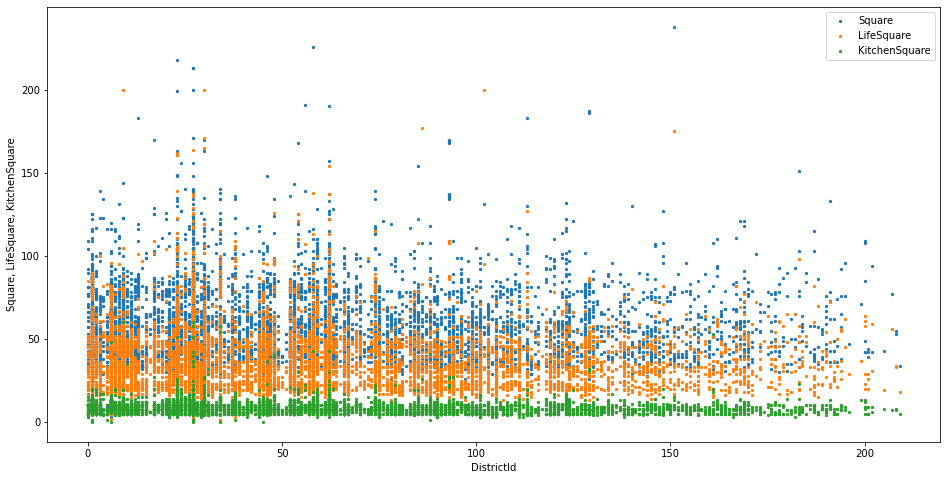

In [89]:
# Square, LifeSqure, KitchenSquare
TypeSquares = ['Square', 'LifeSquare', 'KitchenSquare']

plt.figure(figsize=(16, 8))

for feature in TypeSquares:
    plt.scatter(train_df['DistrictId'], train_df[feature], label=feature, s=5)

plt.xlabel('DistrictId')
plt.ylabel('Square, LifeSquare, KitchenSquare')
plt.legend()
plt.show()

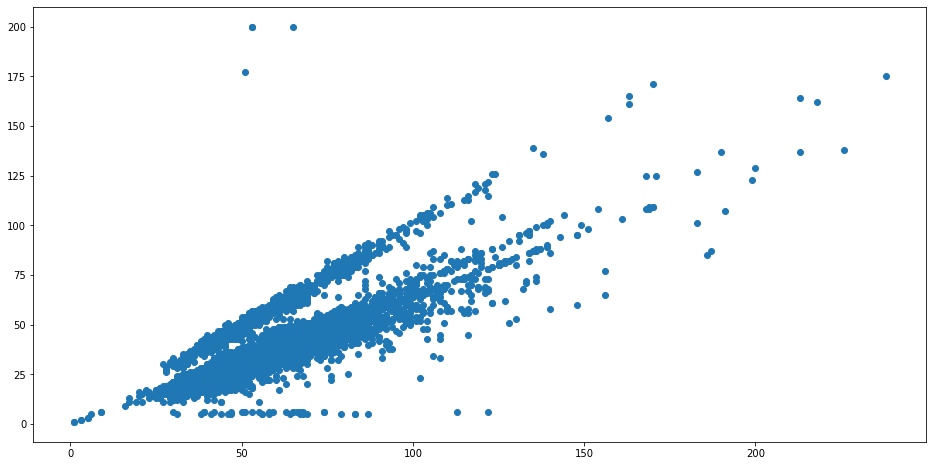

In [90]:
plt.figure(figsize=(16, 8))
plt.scatter(train_df['Square'], train_df['LifeSquare'])
plt.show()

#### ~ class DataPreprocessing

In [ ]:
class DataPreprocessing:
    """Preparation of initial data"""
    
    def __init__(self):
        """Class parameters"""
        self.medians = None
        self.binary_to_numbers = None
    
    def fit(self, X):
        """saving statistics"""
        # Calculation of medians
        self.medians = X.median()
        
    def transform(self, X):
        """data transformation"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        # HouseFloor, Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X[train_df['HouseFloor'] == 0]['Floor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X[X['Floor'] > X['HouseFloor']]['HouseFloor']
        
        #HouseYear
        X.loc[(X['HouseYear'] < 1900), 'HouseYear'] = int(X['HouseYear'].median())
        X.loc[(X['HouseYear'] > 2020), 'HouseYear'] = 2020

        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['Healthcare_1'].median()
        
        # Healthcare_2
        X.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)   
            
        # Square
        ## Exclude with help chart emissions > 250
        X.loc[(X['Square'] > 250) | (X['Square'] == 0), 'Square'] = X['Square'].median()

        ## The smallest apartments in Moscow --> 8.3 m^2 (to use 8)
        X.loc[X['Square'] < 8, 'Square'] = 8
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[(X['KitchenSquare'].isna()) | (X['KitchenSquare'] > 200), 'KitchenSquare'] = X['KitchenSquare'].median()
        
        #LifeSquare
        X.loc[(X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 3)) | \
              (X['LifeSquare'].isna()), 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 3
        
        ## Create ratio lifeSquare / square (for replace NaN LifeSquare) (by DistrictId)
        district_lsq_mean = X.groupby('DistrictId').mean()['LifeSquare']
        district_sq_mean = X.groupby('DistrictId').mean()['Square']
    
        k_mean_life_square = pd.DataFrame(district_lsq_mean / district_sq_mean, columns=['K_LS_S']).reset_index()
    
        X = X.merge(k_mean_life_square, on=['DistrictId'], how='left')

        X.loc[(X['LifeSquare'].isna()), 'LifeSquare'] = \
        X.loc[(X['LifeSquare'].isna()), 'Square'] * X.loc[(X['LifeSquare'].isna()), 'K_LS_S']
        
        # round features
        X[['Square', 'KitchenSquare', 'LifeSquare']] = X[['Square', 'KitchenSquare', 'LifeSquare']].round()
        
        X.fillna(self.medians, inplace=True)
        
        # type int
        X[['Rooms', 'HouseFloor', 'Square', 'LifeSquare', 'KitchenSquare']]\
        = X[['Rooms', 'HouseFloor', 'Square', 'LifeSquare', 'KitchenSquare']].astype(int)
        
        return X

### 4. Building new features 

In [ ]:
class FeatureGenerator:
    """Generation of new features"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.floor_min = None
        self.floor_max = None
        self.house_year_min = None
        self.house_year_max = None
        self.district_size = None
        self.mean_square_rooms = None
        
    
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 1, 'B': 2}

        # DistrictId
        self.district_size = X['DistrictId'].value_counts()\
        .reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
            .rename(columns={'Price': 'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## Floor, HouseYear
        if y is not None:
            self.floor_min = df['Floor'].min()
            self.floor_max = df['Floor'].max()
            self.house_year_min = df['HouseYear'].min()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'})\
            .rename(columns={'Price': 'MedPriceByFloorYear'})
            
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers) # A -> 0, B -> 1
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on=['DistrictId'], how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # MeanSquareRooms
        self.mean_square_rooms = X.groupby(['DistrictId'], as_index=False)[['Rooms', 'LifeSquare']].sum()
        
        self.mean_square_rooms['MeanSquareRooms'] = \
        (self.mean_square_rooms['LifeSquare'] / self.mean_square_rooms['Rooms']).round().astype(int)
        self.mean_square_rooms.drop(columns=['Rooms', 'LifeSquare'], inplace=True)
        X = X.merge(self.mean_square_rooms, on=['DistrictId'], how='left')
        
        
        # More Categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        #target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        return X
    
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], include_lowest=True, bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X
    
    
    def year_to_cat(self, X):
        bins= [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        
        return X
    
    

### 5. Feature selection